<a href="https://colab.research.google.com/github/hwnam5/ajou_TogetherEachSW/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras import layers, models
from tensorflow.keras.activations import softmax

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


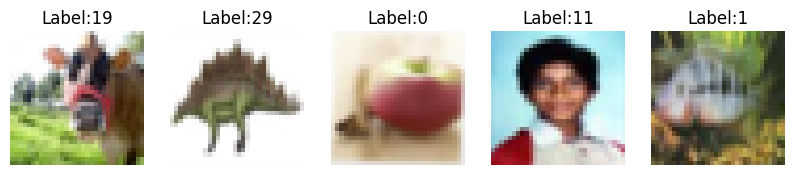

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar100.load_data()

num_classes = 100

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_x[i])
    plt.title(f"Label:{train_y[i][0]}")
    plt.axis('off')
plt.show()


In [5]:
# 정규화 진행
print(f"Befor scaling max and min: {train_x.max()}, {train_x.min()}")
train_x = train_x / 255.0
test_x = test_x / 255.0
print(f"After scaling max and min: {train_x.max()}, {train_x.min()}")

Befor scaling max and min: 255, 0
After scaling max and min: 1.0, 0.0


In [6]:
# 모델의 파라미터 정의
input_shape = (32, 32, 3) # 입력 이미지의 shape
batch_size = 64 # 한번에 학습할 데이터의 개수, 트랜스포머에서는 병렬처리가 용이하므로 큰 값을 사용

image_size = 72 # 패치 분할을 위한 입력 이미지를 재조정할 사이즈
patch_size = 6 # 이미지를 나눌 패치의 사이즈, 각 이미지는 patch_size x patch_size 크기의 패치로 나누어진다
num_patches = (image_size // patch_size) ** 2 # 이미지를 나눌 패치의 개수

learning_rate = 1e-3 # 학습률
weight_decay = 1e-4 # 가중치 감쇠, 오버피팅을 방지
epochs = 30

transformer_layers = 4 # 트랜스포머 내부의 인코더 레이어의 수, 더 많은 레이어는 모델의 복잡도와 학습 능력을 증가시킴, but 더 많은 계산량이 필요
projection_dim = 64 # 패치를 투영할 때의 차원 수, 트랜스포머의 내부 차원과 관련이 있음
num_heads = 4 # 멀티 헤드 어텐션에서의 헤드 수, 여러 개의 헤드를 사용하면 모델이 다양한 정보를 벙렬로 처리할 수 있음

transformer_units = [projection_dim * 2, projection_dim] # 트랜스포머의 퍼드포워드 네트워크에서 사용되는 유닛의 수. 이 배열은 각 레이어에서의 유닛 수를 나타냄
mlp_head_units = [2048, 1024] # 트랜스포머의 최종 레이어에서 사용되는 유닛의 수

In [7]:
class PatchTokenization(layers.Layer):
    def __init__(self, image_size=image_size, patch_size=patch_size, num_patches=num_patches, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, images):
        #입력 이미지를 패치로 나눔
        patches = tf.image.extract_patches(images = images,
                                           sizes=[1, self.patch_size, self.patch_size, 1], # 패치의 크기
                                           strides=[1, self.patch_size, self.patch_size, 1], # 패치의 간격
                                           rates=[1, 1, 1, 1],
                                           padding='VALID') # 이미지 가장자리를 잘라내어 정확히 패치가 맞도록 함
        flat_patches = self.flatten_patches(patches) # 패치 평탄화
        tokens = self.projection(flat_patches) # 패치를 투영(각 패치를 고정된 사이즈의 벡터로 매핑) => transformer의 입력으로 사용
        return (tokens, patches)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


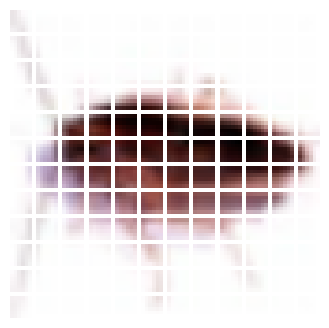

In [8]:
image = train_x[np.random.choice(range(train_x.shape[0]))]
resized_image = tf.image.resize(tf.convert_to_tensor([image]), (image_size, image_size))

# patch_tokenizer = PatchTokenization()
# tokens, patches = patch_tokenizer(resized_image)
(token, patch) = PatchTokenization()(resized_image) # 객체를 함수처럼 호출하여 사용 (call 메서드가 호출됨)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count += 1
        image = tf.reshape(patch[row, col], (patch_size, patch_size, 3))
        plt.imshow(image)
        plt.axis('off')
plt.show()

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_heads=num_heads, projection_dim=projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        # 각 패치의 위치에 대한 학습 가능한 임베딩을 생성 (패치의 토큰과 위치 임베딩을 더해 트랜스포머의 입력으로 사용)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim) # 투영된 차원과 위치 임베딩은 같은 차원을 사용
        self.positions = tf.range(start=0, limit=num_patches, delta=1) # 패치의 위치에 대한 인덱스를 생성성

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions # 위치 정보 추가
        # 모델이 패치들 사이의 관계와 이미지 내에서 각 패치의 위치를 고려할 수 있게 함
        return encoded_patches

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    x = layers.Normalization(axis=-1)(inputs)
    x = layers.Resizing(image_size, image_size)(x) # 이미지를 정해진 크기로 재조정
    (tokens, _) = PatchTokenization()(x) # 이미지를 패치로 분할 후 각 패치를 투영
    encoded_patches = PatchEncoder()(tokens) # 패치 위치 정보 인코딩

    attention_time = 0
    ff_time = 0

    for _ in range(transformer_layers):
        # 멀티 헤드 어텐션과 퍼드포워드 네트워크를 포함하는 트랜스포머 레이어
        start_time = time.time()
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        attention_time += time.time() - start_time

        x2 = layers.Add()([attention_output, encoded_patches])

        start_time = time.time()
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        ff_time += time.time() - start_time

        encoded_patches = layers.Add()([x3, x2])

    print(f"Attention time : {attention_time}, feed forward time : {ff_time}")

    x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = layers.Flatten()(x)
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes)(x) # num_classes개의 클래스로 분류
    model = models.Model(inputs=inputs, outputs=outputs)

    model.attention_time = attention_time
    model.ff_time = ff_time
    return model

In [12]:
def predict_with_time(model, input_data):
  predictions = model(input_data)

  attention_time = model.attention_time
  ff_time = model.ff_time

  return predictions, attention_time, ff_time

In [13]:
# 코사인 감쇠 스케줄링 : 학습률을 점진적으로 감소시키는 방법
class CosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError('Total_steps must be larger or equal to warmup_steps.')
        cos_annealed_lr = tf.cos(self.pi * (tf.cast(step, tf.float32) - self.warmup_steps) / float(self.total_steps - self.warmup_steps))
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0 :
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError('Learning_rate_base must be larger or equal to warmup_learning_rate.')
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_lr = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_lr, learning_rate)

        return tf.where(step > self.total_steps, 0.0, learning_rate, name='learning_rate')

In [14]:
total_steps = int((len(train_x) / batch_size) * epochs)
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = CosineDecay(learning_rate_base=learning_rate, total_steps=total_steps, warmup_learning_rate=0.0, warmup_steps=warmup_steps)

In [16]:
vit = create_vit_classifier()

optimizer = tf.keras.optimizers.Adam(learning_rate = scheduled_lrs, weight_decay=weight_decay)

vit.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'), #모델 정확도
                      tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')]) # 모델의 상위 5개 예측 정확도

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'patch_tokenization_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Attention time : 0.11971926689147949, feed forward time : 0.08585786819458008


In [17]:
history = vit.fit(x = train_x, y = train_y, batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - accuracy: 0.0173 - loss: 4.8938 - top-5-accuracy: 0.0808 - val_accuracy: 0.0777 - val_loss: 4.0378 - val_top-5-accuracy: 0.2637
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0671 - loss: 4.1584 - top-5-accuracy: 0.2248 - val_accuracy: 0.1317 - val_loss: 3.7224 - val_top-5-accuracy: 0.3551
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0941 - loss: 3.9184 - top-5-accuracy: 0.2950 - val_accuracy: 0.1743 - val_loss: 3.5119 - val_top-5-accuracy: 0.4280
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1249 - loss: 3.7387 - top-5-accuracy: 0.3523 - val_accuracy: 0.1981 - val_loss: 3.3437 - val_top-5-accuracy: 0.4826
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1704 - loss: 3.4442 - top-5-accuracy: 0.4376 - val_accuracy: 0.2313 - val_loss: 3.1191 - val_top-5-accuracy: 0.5216
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2205 - loss: 3.1522 - 

In [18]:
vit.evaluate(test_x, test_y)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3808 - loss: 3.5999 - top-5-accuracy: 0.6727


[3.6185121536254883, 0.3815999925136566, 0.669700026512146]

In [21]:
image = train_x[np.random.choice(range(train_x.shape[0]))]
image = np.expand_dims(image, axis=0)
predictions, attention_time, ff_time = predict_with_time(vit, image)
predictions = softmax(predictions)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class : {predicted_class}")
print(f"Total attention_time : {attention_time}")
print(f"Total ff_time : {ff_time}")

Predicted class : [90]
Total attention_time : 0.11971926689147949
Total ff_time : 0.08585786819458008
